# Definición del proyecto de datos

Todo este proyecto tiene su base en la obtención de ciertos insights a partir de 3 bases de datos, las cuales tiene como cobertura geográfica el estado de los ángeles de estados unidos, es decir, es un proyecto donde en particular se estudiara las relaciones entre las diferentes bases de datos donde la región a estudiar son los ángeles.

- Crimen

- Negocios

- Vivienda

El contexto, es simple, trabajamos para el gobierno como alcalde de la ciudad y por tanto, las decisiones que se tomen, deberán de ser tomadas con una perspectiva meramente política, por ello es que los objetivos de este análisis deben de centrarse en la obtención de accionables claros a partir de las relaciones e interacciones encontradas en las bases de datos.

Los ángeles se dividen en 114 vecindarios, sobre los cuales se deberán de realizar el análisis, es decir, la investigación es a nivel de vecindarios. Por tanto, un punto relevante es evaluar la granularidad de la información en las bases de datos así como preguntas de la siguiente naturaleza

¿Qué vecindarios tienen una mayor tasa de muerte de negocios?, ¿se relaciona con la tasa de crimen?
¿Qué vecindarios tienen la mayor tasa de crimen?, ¿necesitan mayor atención policial?
¿Está esto afectando a los precios de las propiedades?  

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd                # Manejo de datos geoespaciales :contentReference[oaicite:8]{index=8}
from shapely.geometry import Point     # Construcción de geometrías puntuales :contentReference[oaicite:9]{index=9}
import contextily as cx

import requests
import io
from http.client import IncompleteRead

from sklearn.neighbors import BallTree

import statsmodels.api as sm

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.oneway import test_scale_oneway
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.nonparametric import rank_compare_2indep

In [2]:
sns.set_style("darkgrid")
#pd.options.display.float_format = "{:,.0f}".format

# Mostrar todas las columnas sin (…)  
pd.set_option('display.max_columns', None)

In [3]:
# URLs de descarga
business_url = "https://data.lacity.org/api/views/r4uk-afju/rows.csv?accessType=DOWNLOAD"     # Listado de negocios :contentReference[oaicite:11]{index=11}

areas_url    = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson" # Área por vecindario :contentReference[oaicite:13]{index=13}
bounds_url   = "https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson" # Límites de vecindario :contentReference[oaicite:14]{index=14}
census_url   = "https://data.lacity.org/api/views/nwj3-ufba/rows.csv?accessType=DOWNLOAD"      # Censo 2010 por consejo :contentReference[oaicite:15]{index=15}


In [4]:
def fetch_csv_stream(url: str, timeout: int = 60) -> io.StringIO:
    """
    Descarga un CSV por streaming.  
    En caso de IncompleteRead, reutiliza los bytes parciales descargados.
    """
    try:
        resp = requests.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        # Leer todo el texto (posible IncompleteRead aquí)
        text = resp.text
    except IncompleteRead as e:
        # e.partial es un bytes con lo descargado antes de la excepción
        print('Incompleto:', e.partial)
        text = e.partial.decode('utf-8', errors='replace')
    return io.StringIO(text)

# Definición de requerimientos de datos

En este caso nuestro objetivo es claro, enconetrar tendencias en la clasificación, edad, ubicación y distribución de los negocios. En esete sentido nuestro objetivo primordial es encontrar las relaciones claves entre los datos de los negocio y su ubicación o vecindario.

Por tanto, los requerimientos se encuentran expresados como la estructura clave que tiene que tener la base de datos para poder construir las variables potenciales para el análisis y construcción de los KPIs. Es decir, el objetivo es realizar un tratamiento de datos lo suficientemente robusto para construir las siguientes variables:
- Densidad de negocios por vecindario
- Tipos de negocios
- Churn date de negocios por vecindario
- Edad promedio de los negociso

Cada una de estas variable tiene diferentes variantes las cuales pueden ser realizadas en función de los requerimientos de los KPIs. Sin embargo comenzaremos definiendo cual es el calculo a realizar para obtener cada una de estas variables.

**Densidad de negocios por vecindario**

La densidad de negocios por vecindario se define como el número de negocios por vecindario dividido entre el número de negocios maximo en el estado.

**Tipos de negocios**

Esta variable nosotros la definiremos como la suma de el producto de la probabilidad de que cada tipo de negocio exista en un vecindario por la cantidad de negocios de este tipo en el vecindario entre el total de negocios en el vecindario.

$$
V \;=\;\sum_{i=1}^{k} P_i \;\frac{n_i}{N}
$$

_Interpretación_ 
- $T=\{1,...,k\}$ conjunto con el tipo de negocios 
- $ \frac{n_i}{N}$ es la proporción de negocios de tipo $i$ en el vecindario.  
- $P_i$ pondera esa proporción según la probabilidad de que dicho tipo exista.  
- En otras palabras, 𝑉 es un promedio ponderado de las proporciones de cada tipo, donde el peso refleja la probabilidad de su existencia.

**Churn date de negocio por vecindario**

churn date será definida como la variable de la tasa de el número de negocios que han cerrado en un vecindario hasta $x$ fecha dividido entre el número total de negocios en ese vecindario hasta la miems $x$ fecha. es decir, es una tasa acumulada

**Edad promedio de los negocios**

Es simplemente la suma de la diferencia entre la fecha de cierre y la fecha de apertura de un negocio dividido entre el número total de negocios en el vecindario.

Con esto en mente, se procede a realizar los calculos dentro del df con el objetivo de obtener estas variables


In [5]:
business_bufer = fetch_csv_stream(business_url)
business_df = pd.read_csv(business_bufer, low_memory=False)

del business_bufer

neighborhoods = gpd.read_file(areas_url)

In [6]:
business_df.head(2)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,444130.0,Hardware stores,0,10/01/2020,NaN,"(33.9581, -118.2926)"
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,09/03/2020,NaN,"(33.9597, -118.3028)"


In [7]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607924 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   LOCATION ACCOUNT #         1607924 non-null  object 
 1   BUSINESS NAME              1607924 non-null  object 
 2   DBA NAME                   246256 non-null   object 
 3   STREET ADDRESS             1607822 non-null  object 
 4   CITY                       1607814 non-null  object 
 5   ZIP CODE                   1607924 non-null  object 
 6   LOCATION DESCRIPTION       1607801 non-null  object 
 7   MAILING ADDRESS            369932 non-null   object 
 8   MAILING CITY               369944 non-null   object 
 9   MAILING ZIP CODE           369813 non-null   object 
 10  NAICS                      628889 non-null   float64
 11  PRIMARY NAICS DESCRIPTION  628889 non-null   object 
 12  COUNCIL DISTRICT           1607924 non-null  int64  
 13  LOCATION STA

In [8]:
neighborhoods.head(2)

,OBJECTID,name,geometry
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0..."
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.4424 34.26..."


Ya que nuestro análisis se centra en encontrar las relaciones que existene entre las diversas variables potenciales y las regiones por vecindario, aquellos registros los cuales no cuenten con la información de la ubicación del negocio son irrelevantes, además, de que dado que la cantidad de registros es muy grande la calidad de algún proceso de imputación podría ponerse en duda y por tanto para este análisis se opta por eliminar aquellos registros que no cuenten con la información de la ubicación del negocio.

Por lo que esto debera de ser considerado en los resultados finales.

In [9]:
business_df['LOCATION'].isnull().sum()/len(business_df)

np.float64(0.583480313746172)

In [10]:
# Codigo que contiene el proceso para asignar las cordendas geográficas a los negocios
# Y convertir el DataFrame a un GeoDataFrame

#Columna con las coordenadas
coord_col = 'LOCATION'

# 1. Eliminar filas sin coordenadas
df_clean = business_df.dropna(subset=[coord_col]).copy()

# 2. Limpiar paréntesis y espacios sobrantes
coords = df_clean[coord_col].astype(str).str.strip('()')

# 3. Separar en dos columnas y convertir a tipo numérico
df_clean[['Latitude', 'Longitude']] = (
    coords
    .str.split(',', expand=True)        # separa en dos columnas
    .apply(lambda col: col.str.strip()) # quita espacios
    .astype(float)                      # convierte a float
)

# 4. Convertir el df_clean a GeoDataFrame
gdf_business = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['Longitude'], df_clean['Latitude']),
    crs="EPSG:4326"  # Coord. reference system GPS
)

gdf_business.head(2)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,444130.0,Hardware stores,0,10/01/2020,NaN,"(33.9581, -118.2926)",33.9581,-118.2926,POINT (-118.2926 33.9581)
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,09/03/2020,NaN,"(33.9597, -118.3028)",33.9597,-118.3028,POINT (-118.3028 33.9597)


In [11]:
#Realizando la unión entre entre el GeoDataFrame de negocios y el GeoDataFrame de vecindarios
#Esto tendrá como resultado un nuevo GeoDataFrame con las cordenadas puntuales de los negocios
#Así como el nombre del vecindario al que pertenecen
gdf_joined = gpd.sjoin(
    gdf_business,
    neighborhoods[['name', 'geometry']],
    how='left',
    predicate='intersects'
)

gdf_joined[['BUSINESS NAME', 'Latitude', 'Longitude', 'name']].head()

,BUSINESS NAME,Latitude,Longitude,name
0,MARIA OFELIA NUNEZ,33.9581,-118.2926,NaN
1,ONE STOP HOLISTIC HEALTH LLC,33.9597,-118.3028,Gramercy Park
2,"CHOE SHOW, LLC",34.0594,-118.3135,Koreatown
3,SANTOS ANTONIO RAMOS AJPACAJA,34.2081,-118.5684,Winnetka
4,ASHLEY-ANN FELIX,33.7380,-118.2861,San Pedro


In [12]:
#Renonbrando las columna de name con neighborhood dado que esta tiene el nombre de los vecindarios
gdf_joined.rename(columns={'name': 'neighborhoods'}, inplace=True)

In [13]:
#Transformando las columnas de fechas a el tipo de dato datetime
gdf_joined["LOCATION START DATE"] = pd.to_datetime(gdf_joined["LOCATION START DATE"], format="%m/%d/%Y", errors='coerce')
gdf_joined["LOCATION END DATE"] = pd.to_datetime(gdf_joined["LOCATION END DATE"], format="%m/%d/%Y", errors='coerce')

In [14]:
gdf_joined["Year star"] = gdf_joined["LOCATION START DATE"].dt.year
gdf_joined["Year end"] = gdf_joined["LOCATION END DATE"].dt.year
gdf_joined["Month star"] = gdf_joined["LOCATION START DATE"].dt.month
gdf_joined["Month end"] = gdf_joined["LOCATION END DATE"].dt.month

In [15]:
len(gdf_joined["neighborhoods"].unique())

115

In [16]:
gdf_joined['neighborhoods'].isnull().sum()/len(gdf_joined)

np.float64(0.2182492114271042)

# Tratamiento  de datos

## Duplicados

Ya que los datos duplicados pueden producir un sesgo proporcional al numero de estos que se encuentren dentro del data set, es importantes antes de realizar cualquier proceso de análisis o incluso imputación tratar esta clase de datos, determinar sus origenes y razones por las cuales es posible que se hayan duplicado y en su caso eliminarlos para evitar cualquier sesgo en el análisis posterior.


In [17]:
gdf_joined.duplicated().sum()

np.int64(0)

In [18]:
gdf_joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 669881 entries, 0 to 1607920
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   LOCATION ACCOUNT #         669881 non-null  object        
 1   BUSINESS NAME              669881 non-null  object        
 2   DBA NAME                   221508 non-null  object        
 3   STREET ADDRESS             669877 non-null  object        
 4   CITY                       669829 non-null  object        
 5   ZIP CODE                   669881 non-null  object        
 6   LOCATION DESCRIPTION       669839 non-null  object        
 7   MAILING ADDRESS            314782 non-null  object        
 8   MAILING CITY               314788 non-null  object        
 9   MAILING ZIP CODE           314672 non-null  object        
 10  NAICS                      584597 non-null  float64       
 11  PRIMARY NAICS DESCRIPTION  584597 non-null  obje

In [19]:
gdf_joined.duplicated(subset=['BUSINESS NAME']).sum()

np.int64(44557)

In [20]:
mask = gdf_joined.duplicated(subset=['BUSINESS NAME'])

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME']).head(6)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
542103,0000977695-0001-8,1 DAY PAINT & BODY CENTERS INC,NaN,3412 W PICO BLVD,LOS ANGELES,90019-4531,3412 PICO 90019-4531,NaN,NaN,NaN,NaN,NaN,10,1971-08-01,2002-12-31,"(34.0471, -118.3177)",34.0471,-118.3177,POINT (-118.3177 34.0471),2.0,Arlington Heights,1971.0,2002.0,8.0,12.0
81401,0000117923-0001-6,1 DAY PAINT & BODY CENTERS INC,NaN,7607 VAN NUYS BLVD,VAN NUYS,91405-1359,7607 VAN NUYS 91405-1359,11766 WILSHIRE BLVD FLOOR #9TH,LOS ANGELES,90025-6538,811120.0,"Automotive body, paint, interior, & glass repair",2,1977-07-28,2013-10-25,"(34.2086, -118.4487)",34.2086,-118.4487,POINT (-118.4487 34.2086),96.0,Van Nuys,1977.0,2013.0,7.0,10.0
90561,0000117923-0003-2,1 DAY PAINT & BODY CENTERS INC,NaN,3153 W PICO BLVD,LOS ANGELES,90019-4710,3153 PICO 90019-4710,POST OFFICE BOX #3037,TORRANCE,90510-3037,423400.0,Professional & commercial equipment & supplies,10,1970-01-01,2009-08-28,"(34.0471, -118.3103)",34.0471,-118.3103,POINT (-118.3103 34.0471),43.0,Harvard Heights,1970.0,2009.0,1.0,8.0
1007380,0002789714-0001-1,1 K TRANSPORTATION LLC,NaN,626 E 90TH STREET,LOS ANGELES,90002-1610,626 90TH 90002-1610,234 E 158TH STREET,GARDENA,90248-2519,492000.0,Couriers & messengers,9,2016-01-01,NaT,"(33.9547, -118.2645)",33.9547,-118.2645,POINT (-118.2645 33.9547),37.0,Green Meadows,2016.0,NaN,1.0,NaN
1196724,0003276448-0001-5,1 K TRANSPORTATION LLC,NaN,234 E 158TH STREET,GARDENA,90248-2519,234 158TH 90248,234 E 158TH STREET,GARDENA,90248-2519,484110.0,"General freight trucking, local",0,2015-01-06,NaT,"(33.8877, 33.8877)",33.8877,33.8877,POINT (33.8877 33.8877),NaN,NaN,2015.0,NaN,1.0,NaN
1557499,0003399505-0002-3,1 METHOD CORP,NaN,2210 SELBY AVENUE,LOS ANGELES,90064-2028,2210 Selby 90064-2028,721 SAN LORENZO STREET,SANTA MONICA,90402-1323,621399.0,Offices of all other miscellaneous health prac...,5,2024-01-01,NaT,"(34.0452, -118.4285)",34.0452,-118.4285,POINT (-118.4285 34.0452),107.0,West Los Angeles,2024.0,NaN,1.0,NaN


In [21]:
gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE']).sum()


np.int64(7154)

In [22]:
mask = gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE'])

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME']).head(6)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
1552633,0003399505-0004-0,1 METHOD CORP,NaN,10127 ROSSBURY PLACE,LOS ANGELES,90064-4827,10127 Rossbury 90064-4827,721 SAN LORENZO STREET,SANTA MONICA,90402-1323,621400.0,Outpatient care centers,5,2024-01-01,NaT,"(34.0347, -118.4051)",34.0347,-118.4051,POINT (-118.4051 34.0347),19.0,Cheviot Hills,2024.0,NaN,1.0,NaN
1557499,0003399505-0002-3,1 METHOD CORP,NaN,2210 SELBY AVENUE,LOS ANGELES,90064-2028,2210 Selby 90064-2028,721 SAN LORENZO STREET,SANTA MONICA,90402-1323,621399.0,Offices of all other miscellaneous health prac...,5,2024-01-01,NaT,"(34.0452, -118.4285)",34.0452,-118.4285,POINT (-118.4285 34.0452),107.0,West Los Angeles,2024.0,NaN,1.0,NaN
1555250,0003399505-0003-1,1 METHOD CORP,NaN,3142 PATRICIA AVENUE,LOS ANGELES,90064-4718,3142 Patricia 90064-4718,721 SAN LORENZO STREET,SANTA MONICA,90402-1323,621111.0,Offices of physicians (except mental health sp...,5,2024-01-01,NaT,"(34.0342, -118.4088)",34.0342,-118.4088,POINT (-118.4088 34.0342),19.0,Cheviot Hills,2024.0,NaN,1.0,NaN
766434,0002403665-0002-3,1021 1132 N WILMINGTON AVENUE LLC,OCEAN BREEZE APARTMENTS,1132 N WILMINGTON BLVD,WILMINGTON,90744-3200,1132 WILMINGTON 90744-3200,POST OFFICE BOX #57039,LOS ANGELES,90057-0039,531100.0,Lessors of real estate (including mini warehou...,15,2005-06-13,NaT,"(33.7851, -118.2746)",33.7851,-118.2746,POINT (-118.2746 33.7851),109.0,Wilmington,2005.0,NaN,6.0,NaN
769676,0002403665-0001-5,1021 1132 N WILMINGTON AVENUE LLC,OCEAN BREEZE APARTMENTS,1021 N WILMINGTON BLVD,WILMINGTON,90744-3252,1021 WILMINGTON 90744-3252,POST OFFICE BOX #57039,LOS ANGELES,90057-0039,531100.0,Lessors of real estate (including mini warehou...,15,2005-06-13,NaT,"(33.7826, -118.2744)",33.7826,-118.2744,POINT (-118.2744 33.7826),109.0,Wilmington,2005.0,NaN,6.0,NaN
121225,0000177623-0001-0,10801 NATIONAL LLC,NATIONAL INVESTMENT CO,10801 NATIONAL BLVD #601,LOS ANGELES,90064-4126,10801 NATIONAL 90064-4126,NaN,NaN,NaN,812930.0,Parking lots & garages,5,1978-09-01,NaT,"(34.0311, -118.4199)",34.0311,-118.4199,POINT (-118.4199 34.0311),70.0,Palms,1978.0,NaN,9.0,NaN


In [23]:
gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE']).sum()

np.int64(924)

In [24]:
mask = gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE'])

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME']).head(6)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
121225,0000177623-0001-0,10801 NATIONAL LLC,NATIONAL INVESTMENT CO,10801 NATIONAL BLVD #601,LOS ANGELES,90064-4126,10801 NATIONAL 90064-4126,NaN,NaN,NaN,812930.0,Parking lots & garages,5,1978-09-01,NaT,"(34.0311, -118.4199)",34.0311,-118.4199,POINT (-118.4199 34.0311),70.0,Palms,1978.0,NaN,9.0,NaN
116579,0000177623-0002-8,10801 NATIONAL LLC,NATIONAL INVESTMENT CO,10801 NATIONAL BLVD #601,LOS ANGELES,90064-4126,10801 NATIONAL 90064-4126,NaN,NaN,NaN,531100.0,Lessors of real estate (including mini warehou...,5,1978-09-01,NaT,"(34.0311, -118.4199)",34.0311,-118.4199,POINT (-118.4199 34.0311),70.0,Palms,1978.0,NaN,9.0,NaN
1207597,0002508179-0005-1,110 SUNSHINE SMOOTHIES INC,QWENCH VERMONT,1528 N VERMONT AVENUE #B,LOS ANGELES,90027-5311,1528 VERMONT 90027-5311,800 S FIGUEROA STREET SUITE #925,LOS ANGELES,90017-2609,235110.0,"Plumbing, Heating, and Air-Conditioning Contra...",13,2010-06-16,NaT,"(34.0989, -118.2917)",34.0989,-118.2917,POINT (-118.2917 34.0989),25.0,East Hollywood,2010.0,NaN,6.0,NaN
833404,0002508179-0004-2,110 SUNSHINE SMOOTHIES INC,DRNK /QWENCH CITY MALL,201 N LOS ANGELES STREET UNIT #24,LOS ANGELES,90012-3317,201 LOS ANGELES 90012-3317,NaN,NaN,NaN,722300.0,Special food services (including food service ...,14,2010-06-16,NaT,"(34.0534, -118.2408)",34.0534,-118.2408,POINT (-118.2408 34.0534),23.0,Downtown,2010.0,NaN,6.0,NaN
1298367,0002508179-0002-6,110 SUNSHINE SMOOTHIES INC,NaN,750 W 7TH STREET UNIT #G620,LOS ANGELES,90017-3700,750 7TH 90017-3700,800 S FIGUEROA STREET SUITE #925,LOS ANGELES,90017-2609,NaN,NaN,14,2010-06-16,NaT,"(34.0476, -118.2589)",34.0476,-118.2589,POINT (-118.2589 34.0476),23.0,Downtown,2010.0,NaN,6.0,NaN
841923,0002508179-0006-9,110 SUNSHINE SMOOTHIES INC,DRNK VERMONT,1528 N VERMONT AVENUE #C,LOS ANGELES,90027-5311,1528 VERMONT 90027-5311,NaN,NaN,NaN,722300.0,Special food services (including food service ...,13,2010-06-16,NaT,"(34.0989, -118.2917)",34.0989,-118.2917,POINT (-118.2917 34.0989),25.0,East Hollywood,2010.0,NaN,6.0,NaN


In [25]:
gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE', 'NAICS']).sum()

np.int64(620)

In [26]:
mask = gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE', 'NAICS'])

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME']).head(6)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
592704,0003453584-0001-6,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
1183201,0003319832-0001-6,12 OAKS PARKING LLC,NaN,6225 W CENTURY BLVD,LOS ANGELES,90045-5311,6225 CENTURY 90045,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,11,2022-06-30,NaT,"(33.9463, 33.9463)",33.9463,33.9463,POINT (33.9463 33.9463),NaN,NaN,2022.0,NaN,6.0,NaN
537050,0003319832-0002-4,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
1093524,0003164611-0002-1,1661 ADAMS LLC,NaN,1665 W ADAMS BLVD,LOS ANGELES,90007-1533,1665 ADAMS 90007-1533,NaN,NaN,NaN,621610.0,Home health care services,8,2019-03-19,NaT,"(34.0331, -118.2996)",34.0331,-118.2996,POINT (-118.2996 34.0331),0.0,Adams-Normandie,2019.0,NaN,3.0,NaN
1100021,0003164611-0001-2,1661 ADAMS LLC,NaN,1661 W ADAMS BLVD,LOS ANGELES,90007-1533,1661 ADAMS 90007-1533,NaN,NaN,NaN,621610.0,Home health care services,8,2019-03-19,NaT,"(34.0331, -118.2993)",34.0331,-118.2993,POINT (-118.2993 34.0331),0.0,Adams-Normandie,2019.0,NaN,3.0,NaN
642102,0002181802-0001-6,2 LOOP FILMS INC,NaN,7901 MELROSE AVENUE SUITE #201,LOS ANGELES,90046-7173,7901 MELROSE 90046-7173,1212 HILLDALE AVENUE,WEST HOLLYWOOD,90069-1823,NaN,NaN,5,1999-06-19,NaT,"(34.0837, -118.3615)",34.0837,-118.3615,POINT (-118.3615 34.0837),32.0,Fairfax,1999.0,NaN,6.0,NaN


In [27]:
gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE', 'NAICS', 'LOCATION END DATE']).sum()

np.int64(597)

In [28]:
mask = gdf_joined.duplicated(subset=['BUSINESS NAME', 'LOCATION START DATE', 'ZIP CODE', 'NAICS', 'LOCATION END DATE'])

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME']).head(6)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
537050,0003319832-0002-4,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
1183201,0003319832-0001-6,12 OAKS PARKING LLC,NaN,6225 W CENTURY BLVD,LOS ANGELES,90045-5311,6225 CENTURY 90045,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,11,2022-06-30,NaT,"(33.9463, 33.9463)",33.9463,33.9463,POINT (33.9463 33.9463),NaN,NaN,2022.0,NaN,6.0,NaN
592704,0003453584-0001-6,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
1093524,0003164611-0002-1,1661 ADAMS LLC,NaN,1665 W ADAMS BLVD,LOS ANGELES,90007-1533,1665 ADAMS 90007-1533,NaN,NaN,NaN,621610.0,Home health care services,8,2019-03-19,NaT,"(34.0331, -118.2996)",34.0331,-118.2996,POINT (-118.2996 34.0331),0.0,Adams-Normandie,2019.0,NaN,3.0,NaN
1100021,0003164611-0001-2,1661 ADAMS LLC,NaN,1661 W ADAMS BLVD,LOS ANGELES,90007-1533,1661 ADAMS 90007-1533,NaN,NaN,NaN,621610.0,Home health care services,8,2019-03-19,NaT,"(34.0331, -118.2993)",34.0331,-118.2993,POINT (-118.2993 34.0331),0.0,Adams-Normandie,2019.0,NaN,3.0,NaN
642102,0002181802-0001-6,2 LOOP FILMS INC,NaN,7901 MELROSE AVENUE SUITE #201,LOS ANGELES,90046-7173,7901 MELROSE 90046-7173,1212 HILLDALE AVENUE,WEST HOLLYWOOD,90069-1823,NaN,NaN,5,1999-06-19,NaT,"(34.0837, -118.3615)",34.0837,-118.3615,POINT (-118.3615 34.0837),7.0,Beverly Grove,1999.0,NaN,6.0,NaN


Los siguientes reguistros dado que contiene los campos
- BUSINESS NAME
- LOCATION START DATE
- LOCATION END DATE
- ZIP CODE
- NAICS
- LOCATION DESCRIPTION'

En esencia son practicamente el mismo registro, pues aunque en el análisis podemos apreciar que no existen registros 100% iguales, si existen registros que comparten caracteristicas similares, por lo que los siguientes 410 registros se consideran iguales dada la naturaleza del dataset y por tanto se eliminan, pues se encontro que el unico campo diferente es el que corresponde a LOCATION ACCOUNT # por lo que podemos concluir que dado que este es un ID si existe información redudante dentro del dataset.

Esto ya que a diferencia de las anteriores tablas proyectas, todas contenian algun campo diferente menos la que fue realizada en la siguiente celta.


In [29]:
gdf_joined.duplicated(
    subset=[
        'BUSINESS NAME', 
        'LOCATION START DATE', 
        'ZIP CODE', 
        'NAICS', 
        'LOCATION END DATE', 
        'LOCATION DESCRIPTION'
        ]
    ).sum()

np.int64(410)

In [30]:
mask = gdf_joined.duplicated(
    subset=[
        'BUSINESS NAME', 
        'LOCATION START DATE', 
        'ZIP CODE', 
        'NAICS', 
        'LOCATION END DATE', 
        'LOCATION DESCRIPTION'
        ]
    )

result = gdf_joined.loc[mask, 'BUSINESS NAME']

mask = gdf_joined['BUSINESS NAME'].isin(result)

gdf_joined.loc[mask, :].sort_values(by=['BUSINESS NAME'])

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
537050,0003319832-0002-4,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
592704,0003453584-0001-6,12 OAKS PARKING LLC,NaN,501 SHATTO PLACE,LOS ANGELES,90020-1738,501 Shatto 90020-1738,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,10,2024-11-01,NaT,"(34.0653, -118.2904)",34.0653,-118.2904,POINT (-118.2904 34.0653),52.0,Koreatown,2024.0,NaN,11.0,NaN
1183201,0003319832-0001-6,12 OAKS PARKING LLC,NaN,6225 W CENTURY BLVD,LOS ANGELES,90045-5311,6225 CENTURY 90045,970 CANTON STREET SUITE #B,ROSWELL,30075-3646,812930.0,Parking lots & garages,11,2022-06-30,NaT,"(33.9463, 33.9463)",33.9463,33.9463,POINT (33.9463 33.9463),NaN,NaN,2022.0,NaN,6.0,NaN
642102,0002181802-0001-6,2 LOOP FILMS INC,NaN,7901 MELROSE AVENUE SUITE #201,LOS ANGELES,90046-7173,7901 MELROSE 90046-7173,1212 HILLDALE AVENUE,WEST HOLLYWOOD,90069-1823,NaN,NaN,5,1999-06-19,NaT,"(34.0837, -118.3615)",34.0837,-118.3615,POINT (-118.3615 34.0837),32.0,Fairfax,1999.0,NaN,6.0,NaN
642102,0002181802-0001-6,2 LOOP FILMS INC,NaN,7901 MELROSE AVENUE SUITE #201,LOS ANGELES,90046-7173,7901 MELROSE 90046-7173,1212 HILLDALE AVENUE,WEST HOLLYWOOD,90069-1823,NaN,NaN,5,1999-06-19,NaT,"(34.0837, -118.3615)",34.0837,-118.3615,POINT (-118.3615 34.0837),7.0,Beverly Grove,1999.0,NaN,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339856,0000794843-0001-7,YOSUP D JAHNG/HAISOOK JAHNG,NaN,5774 1/2 W 3RD STREET,LOS ANGELES,90036-3045,5774 3RD 90036-3045,26114 SALINGER LANE,STEVENSON RANCH,91381-1107,812310.0,Coin-operated laundries & drycleaners,5,1989-09-15,2018-01-31,"(34.0689, -118.3456)",34.0689,-118.3456,POINT (-118.3456 34.0689),61.0,Mid-Wilshire,1989.0,2018.0,9.0,1.0
1339856,0000794843-0001-7,YOSUP D JAHNG/HAISOOK JAHNG,NaN,5774 1/2 W 3RD STREET,LOS ANGELES,90036-3045,5774 3RD 90036-3045,26114 SALINGER LANE,STEVENSON RANCH,91381-1107,812310.0,Coin-operated laundries & drycleaners,5,1989-09-15,2018-01-31,"(34.0689, -118.3456)",34.0689,-118.3456,POINT (-118.3456 34.0689),32.0,Fairfax,1989.0,2018.0,9.0,1.0
1099562,0003166619-0001-3,ZULMA CANCHOLA,AVENIDA DEL SOL REALTY,11040 PASO ROBLES AVENUE,GRANADA HILLS,91344-4934,11040 PASO ROBLES 91344-4934,NaN,NaN,NaN,531210.0,Offices of real estate agents & brokers,12,2006-10-01,NaT,"(34.2713, -118.503)",34.2713,-118.5030,POINT (-118.503 34.2713),36.0,Granada Hills,2006.0,NaN,10.0,NaN
657417,0002201185-0001-6,ZULMA CANCHOLA,PEOPLES INSURANCE,8526 VAN NUYS BLVD,PANORAMA CITY,91402-2911,8526 VAN NUYS 91402-2911,NaN,NaN,NaN,NaN,NaN,6,2006-10-01,2010-12-31,"(34.2251, -118.4488)",34.2251,-118.4488,POINT (-118.4488 34.2251),71.0,Panorama City,2006.0,2010.0,10.0,12.0


In [31]:
gdf_joined.drop_duplicates(subset=[
        'BUSINESS NAME', 
        'LOCATION START DATE', 
        'ZIP CODE', 
        'NAICS', 
        'LOCATION END DATE', 
        'LOCATION DESCRIPTION'
        ]
, inplace=True)

In [32]:
gdf_joined.duplicated(
    subset=[
        'BUSINESS NAME', 
        'LOCATION START DATE', 
        'ZIP CODE', 
        'NAICS', 
        'LOCATION END DATE', 
        'LOCATION DESCRIPTION'
        ]
    ).sum()

np.int64(0)

## Nulos

### Análisis de registros nulos eliminados | Location

Para determinar si los registros que eliminamos anteriormente con el objetivo de obtener una muestra la cual contenga el 100% de los registros con la infromación de las ubicaciones de los negocios para así poder relacionarlar las variables potenciales con algún vecindario; no sea una muestra a la cual le hayamos inducido algún sesgo debemos de asegurarnos de que los datos faltantes son completamente al azar (MCAR)

Pues aunque esta pueda tener menor potencia estadística al reducir $N$, podemos asegurar de que no existe un sesgo importante en los resultados obtenidos a través de esta.

Ahora bien, algunos de los metodos para determinar si existen datos faltantes que no son MCAR son:
- Test de Little
- Comparación de distribuciones pre/post eliminación 
- Modelado de la probabilidad de falta

Sin embargo, el test de little supone que las variables son continuas y no categóricas, por lo que no es aplicable en este caso. Por otro lado, y en el mismo sentido la comparación pre/post eliminación pues tiene el mismo inconveniente que el test de little. Por ultimo, para el modelo de probabilidad de falta se suele utilizar una regresión logística, la cual de hecho si puede ser utilizada si las variables se transforman en variables dummy, el problema es que la cantidad de categorias que existen en cada variable es muy grander por lo que puede generar un modelo inestable y sobreajustado, con multicolinealidad, de separación, donde el modelo no converga o un aumenro en la varianza de los coeficientes.

Es por todo lo anterior que dada la naturaleza del data ser se considera a la variable de location y sus datos nulos como faltanes MCAR, pues la variedad de los datos y su cantidad reflejan una falta dependencia entre la ausencia de los datos y el resto de variables.

### Name | neighborhoods

Al análizar la columna que corresponde a los neighborhoods nos damos cuenta que realmente los datos faltantes no son al azar, sino que corresponden a una falla a la hora de asignar el vecindario, pues los negocios que no poseen datos de vecindario son aquellos que se encuentran en la fronteras de los vecindarios y por tanto el algoritmo no logra asignarles uno de manera correcto. 

Por tanto, es que con esto se procedera a imputar los valores a través de un algoritmo BallTree que pertence a Sklearn, el cual permite encontrar los puntos más cercanos a un punto en particular. En este caso, se tomara como punto de referencia el vecindario más cercano al negocio que no tiene vecindario asignado.



In [33]:
gdf_joined.isnull().sum()/len(gdf_joined)

LOCATION ACCOUNT #           0.000000
BUSINESS NAME                0.000000
DBA NAME                     0.669460
STREET ADDRESS               0.000006
CITY                         0.000078
ZIP CODE                     0.000000
LOCATION DESCRIPTION         0.000063
MAILING ADDRESS              0.530128
MAILING CITY                 0.530119
MAILING ZIP CODE             0.530292
NAICS                        0.127306
PRIMARY NAICS DESCRIPTION    0.127306
COUNCIL DISTRICT             0.000000
LOCATION START DATE          0.000105
LOCATION END DATE            0.817129
LOCATION                     0.000000
Latitude                     0.000000
Longitude                    0.000000
geometry                     0.000000
index_right                  0.218295
neighborhoods                0.218295
Year star                    0.000105
Year end                     0.817129
Month star                   0.000105
Month end                    0.817129
dtype: float64

In [34]:
# 1. Separa lo asignado y lo faltante
gdf_missing  = gdf_joined[gdf_joined['neighborhoods'].isna()].copy()
gdf_assigned = gdf_joined[gdf_joined['neighborhoods'].notna()].copy()

In [35]:
# Centroides en radianes (Haversine)
neigh_cent = gdf_joined[['neighborhoods', 'geometry']].copy()


neigh_cent['centroid'] = neigh_cent.geometry.centroid
centroids = np.deg2rad(
    np.c_[neigh_cent.centroid.y.values, neigh_cent.centroid.x.values]
)
tree = BallTree(centroids, metric='haversine')

# Puntos faltantes → radianes
pts = np.deg2rad(np.c_[gdf_missing.geometry.y, gdf_missing.geometry.x])
dist, idx = tree.query(pts, k=1)

gdf_missing['neighborhoods']   = neigh_cent.iloc[idx.flatten()].neighborhoods.values
gdf_missing['dist_k'] = dist.flatten()*6371   # km

/tmp/ipykernel_3731/1750978486.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neigh_cent['centroid'] = neigh_cent.geometry.centroid
/tmp/ipykernel_3731/1750978486.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  np.c_[neigh_cent.centroid.y.values, neigh_cent.centroid.x.values]


In [36]:
gdf_business = pd.concat([gdf_assigned, gdf_assigned], ignore_index=True)
gdf_business.head(2)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
0,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,2020-09-03,NaT,"(33.9597, -118.3028)",33.9597,-118.3028,POINT (-118.3028 33.9597),35.0,Gramercy Park,2020.0,NaN,9.0,NaN
1,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,NaN,NaN,5,2021-03-15,NaT,"(34.0594, -118.3135)",34.0594,-118.3135,POINT (-118.3135 34.0594),52.0,Koreatown,2021.0,NaN,3.0,NaN


In [37]:
gdf_business['neighborhoods'].isnull().sum()/len(gdf_business)

np.float64(0.0)

In [38]:
gdf_business.columns = gdf_business.columns.str.strip()

In [39]:
len(gdf_business)

1046658

### DBA NAME

Ya que el DBA NAME es un campo que expresa el nombre del negocio cuando este es distinto al BUSINESS NAME, este se considera como un campo innecesario para el análisis, pues no aporta información adicional a la ya disponible en data set. Por lo que se eliminara.

In [40]:
gdf_business.drop(columns=['DBA NAME'], inplace=True)

### CITY y STREET ADDRESS 

Por lo insignificante que es la muestra faltante de datos es que se opta por eliminar estos registros, pues no aportan información relevante al análisis y por tanto no es necesario realizar un proceso de imputación.

In [41]:
gdf_business['CITY'].isnull().sum()

np.int64(4)

In [42]:
gdf_business.dropna(subset=['CITY'], inplace=True)
gdf_business['CITY'].isnull().sum()

np.int64(0)

In [43]:
gdf_business['STREET ADDRESS'].isnull().sum()

np.int64(0)

### MAILING

In [44]:
gdf_business.isnull().sum()/len(gdf_business)

LOCATION ACCOUNT #           0.000000
BUSINESS NAME                0.000000
STREET ADDRESS               0.000000
CITY                         0.000000
ZIP CODE                     0.000000
LOCATION DESCRIPTION         0.000034
MAILING ADDRESS              0.544006
MAILING CITY                 0.543987
MAILING ZIP CODE             0.544109
NAICS                        0.122199
PRIMARY NAICS DESCRIPTION    0.122199
COUNCIL DISTRICT             0.000000
LOCATION START DATE          0.000010
LOCATION END DATE            0.800532
LOCATION                     0.000000
Latitude                     0.000000
Longitude                    0.000000
geometry                     0.000000
index_right                  0.000000
neighborhoods                0.000000
Year star                    0.000010
Year end                     0.800532
Month star                   0.000010
Month end                    0.800532
dtype: float64

In [45]:
gdf_business.drop(columns=['MAILING ADDRESS', 'MAILING CITY', 'MAILING ZIP CODE'], inplace=True)

### LOCATION DESCRIPTION

In [46]:
gdf_business['LOCATION DESCRIPTION'].isnull().sum()

np.int64(36)

In [47]:
gdf_business.drop(columns=['LOCATION DESCRIPTION'], inplace=True)

### NAICS y PRIMARY NAICS DESCRIPTION

Para este caso se utilizara un proceso de imputación por modas condicionales, es decir, se asignara el NAICS y PRIMARY NAICS DESCRIPTION a cada registro que corresponde con la moda de este valor para cada vecindario.

In [48]:
gdf_business['NAICS'].isnull().sum()

np.int64(127900)

In [49]:
# 1) Calcula la moda por barrio para cada fila
gdf_business['naics_mode'] = (
    gdf_business
        .groupby('neighborhoods')['NAICS']
        .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
)

# 2) Rellena los NaN originales
gdf_business['NAICS'] = gdf_business['NAICS'].fillna(gdf_business['naics_mode'])
gdf_business.drop(columns=['naics_mode'], inplace=True)


In [50]:
# 1) Calcula la moda por barrio para cada fila
gdf_business['naics_mode'] = (
    gdf_business
        .groupby('neighborhoods')['PRIMARY NAICS DESCRIPTION']
        .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
)

# 2) Rellena los NaN originales
gdf_business['PRIMARY NAICS DESCRIPTION'] = gdf_business['PRIMARY NAICS DESCRIPTION'].fillna(gdf_business['naics_mode'])
gdf_business.drop(columns=['naics_mode'], inplace=True)


### LOCATION START DATE

In [51]:
gdf_business['LOCATION START DATE'].isnull().sum()

np.int64(10)

In [52]:
gdf_business.dropna(subset=['LOCATION START DATE'], inplace=True)

In [53]:
gdf_business['LOCATION START DATE'].isnull().sum()

np.int64(0)

### LOCATION END DATE

En este caso LOCATION END DATE es natural que posea valores nulos pues en mucho casos los negocios que se han aperturado no han cerrado operacione y por tanto no han reportado una fecha de END DATE.

En este sentido podemos decir que este campo posee valores nulos no a azar

In [54]:
gdf_business["LOCATION END DATE"].isnull().sum()/len(gdf_business)

np.float64(0.8005396295206393)

In [55]:
gdf_business.isnull().sum()/len(gdf_business)

LOCATION ACCOUNT #           0.00000
BUSINESS NAME                0.00000
STREET ADDRESS               0.00000
CITY                         0.00000
ZIP CODE                     0.00000
NAICS                        0.00000
PRIMARY NAICS DESCRIPTION    0.00000
COUNCIL DISTRICT             0.00000
LOCATION START DATE          0.00000
LOCATION END DATE            0.80054
LOCATION                     0.00000
Latitude                     0.00000
Longitude                    0.00000
geometry                     0.00000
index_right                  0.00000
neighborhoods                0.00000
Year star                    0.00000
Year end                     0.80054
Month star                   0.00000
Month end                    0.80054
dtype: float64

In [56]:
gdf_business.to_csv("./resources/Business_clean.csv")

Procedemos con la presentación de datos

# Calculo de variables potenciales

## Densidad de negocios por vecindario

**Densidad general de negocios por vecindario**

In [57]:
densidad_negocios_vecindario = gdf_business.groupby('neighborhoods')['BUSINESS NAME'].count().sort_values(ascending=False)/len(gdf_business)
densidad_negocios_vecindario

neighborhoods
Downtown                0.063611
Koreatown               0.033780
Van Nuys                0.032930
Sherman Oaks            0.029299
Hollywood               0.027969
                          ...   
Sepulveda Basin         0.000506
Elysian Park            0.000455
Griffith Park           0.000180
Hansen Dam              0.000088
Chatsworth Reservoir    0.000013
Name: BUSINESS NAME, Length: 114, dtype: float64

**Densidad anual de negocios por vecindario**

In [58]:
mask = gdf_business['Year star'] >= 1990

pt = gdf_business[mask].pivot_table(values='BUSINESS NAME', index='neighborhoods', columns='Year star', aggfunc='count')
pt

Year star,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
neighborhoods,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams-Normandie,24.0,16.0,18.0,20.0,20.0,30.0,22.0,36.0,24.0,34.0,32.0,56.0,54.0,96.0,124.0,90.0,98.0,84.0,74.0,72.0,88.0,96.0,114.0,130.0,136.0,158.0,116.0,136.0,120.0,204.0,110.0,104.0,50.0,34.0,38.0,20.0
Arleta,12.0,16.0,12.0,16.0,14.0,16.0,16.0,40.0,48.0,58.0,68.0,130.0,102.0,154.0,132.0,126.0,132.0,136.0,104.0,104.0,82.0,156.0,186.0,242.0,254.0,302.0,252.0,232.0,278.0,268.0,212.0,160.0,114.0,134.0,106.0,28.0
Arlington Heights,34.0,36.0,22.0,30.0,26.0,52.0,58.0,52.0,38.0,76.0,88.0,90.0,126.0,166.0,202.0,146.0,158.0,170.0,128.0,138.0,152.0,180.0,198.0,228.0,248.0,262.0,258.0,246.0,284.0,294.0,210.0,190.0,104.0,90.0,104.0,48.0
Atwater Village,12.0,18.0,20.0,22.0,38.0,24.0,30.0,44.0,36.0,86.0,92.0,78.0,92.0,142.0,178.0,160.0,148.0,168.0,188.0,138.0,164.0,162.0,216.0,252.0,268.0,278.0,280.0,268.0,332.0,360.0,224.0,216.0,88.0,104.0,72.0,36.0
Baldwin Hills/Crenshaw,16.0,20.0,30.0,30.0,34.0,34.0,42.0,60.0,48.0,90.0,82.0,122.0,162.0,164.0,144.0,146.0,166.0,156.0,148.0,168.0,162.0,190.0,190.0,232.0,258.0,296.0,250.0,340.0,320.0,334.0,316.0,204.0,86.0,108.0,66.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Westwood,58.0,88.0,110.0,106.0,120.0,122.0,138.0,182.0,148.0,230.0,228.0,272.0,250.0,336.0,340.0,356.0,368.0,436.0,402.0,396.0,444.0,484.0,502.0,564.0,610.0,698.0,698.0,652.0,764.0,736.0,580.0,508.0,232.0,194.0,186.0,72.0
Wilmington,82.0,68.0,78.0,56.0,104.0,78.0,92.0,76.0,130.0,148.0,158.0,160.0,172.0,262.0,268.0,210.0,212.0,178.0,162.0,162.0,140.0,198.0,240.0,346.0,372.0,382.0,258.0,296.0,384.0,410.0,232.0,190.0,110.0,116.0,106.0,56.0
Windsor Square,20.0,8.0,20.0,12.0,14.0,22.0,12.0,16.0,34.0,46.0,48.0,68.0,42.0,48.0,56.0,66.0,84.0,78.0,78.0,48.0,62.0,82.0,96.0,88.0,104.0,138.0,142.0,164.0,162.0,136.0,96.0,56.0,40.0,46.0,52.0,20.0


In [59]:
totales = pt.sum(axis=0)

In [60]:
# 3) divide cada columna por su total
pt_rel = pt.div(totales, axis=1)
pt_rel

Year star,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
neighborhoods,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams-Normandie,0.004471,0.002809,0.002865,0.003084,0.002612,0.003342,0.002178,0.002851,0.002017,0.002093,0.001766,0.002715,0.002432,0.003674,0.004224,0.003118,0.003226,0.002549,0.002676,0.002553,0.002891,0.002892,0.003093,0.002984,0.002694,0.002759,0.002171,0.002585,0.001983,0.003488,0.002268,0.002728,0.002485,0.001678,0.002110,0.003084
Arleta,0.002235,0.002809,0.001910,0.002467,0.001829,0.001782,0.001584,0.003168,0.004034,0.003571,0.003752,0.006302,0.004595,0.005893,0.004497,0.004365,0.004345,0.004127,0.003761,0.003688,0.002693,0.004700,0.005046,0.005555,0.005032,0.005273,0.004716,0.004410,0.004595,0.004582,0.004371,0.004196,0.005665,0.006614,0.005886,0.004317
Arlington Heights,0.006334,0.006320,0.003502,0.004625,0.003396,0.005792,0.005743,0.004118,0.003193,0.004679,0.004856,0.004363,0.005676,0.006352,0.006882,0.005058,0.005200,0.005159,0.004629,0.004894,0.004993,0.005423,0.005371,0.005233,0.004913,0.004574,0.004828,0.004676,0.004694,0.005026,0.004330,0.004983,0.005168,0.004442,0.005775,0.007401
Atwater Village,0.002235,0.003160,0.003184,0.003392,0.004963,0.002673,0.002970,0.003485,0.003025,0.005295,0.005077,0.003781,0.004144,0.005434,0.006064,0.005542,0.004871,0.005098,0.006798,0.004894,0.005387,0.004880,0.005860,0.005784,0.005309,0.004854,0.005240,0.005094,0.005487,0.006155,0.004619,0.005665,0.004373,0.005133,0.003998,0.005550
Baldwin Hills/Crenshaw,0.002981,0.003511,0.004776,0.004625,0.004441,0.003787,0.004158,0.004752,0.004034,0.005541,0.004525,0.005914,0.007297,0.006276,0.004906,0.005058,0.005464,0.004734,0.005352,0.005958,0.005321,0.005724,0.005154,0.005325,0.005111,0.005168,0.004678,0.006463,0.005289,0.005710,0.006516,0.005350,0.004274,0.005331,0.003665,0.006475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Westwood,0.010805,0.015449,0.017510,0.016343,0.015674,0.013589,0.013663,0.014415,0.012437,0.014161,0.012581,0.013186,0.011261,0.012858,0.011583,0.012332,0.012112,0.013231,0.014537,0.014044,0.014584,0.014581,0.013618,0.012945,0.012084,0.012187,0.013061,0.012394,0.012628,0.012583,0.011959,0.013323,0.011529,0.009576,0.010329,0.011101
Wilmington,0.015276,0.011938,0.012416,0.008634,0.013584,0.008688,0.009109,0.006019,0.010924,0.009112,0.008719,0.007756,0.007748,0.010026,0.009130,0.007274,0.006978,0.005402,0.005858,0.005745,0.004599,0.005965,0.006511,0.007942,0.007369,0.006669,0.004828,0.005627,0.006347,0.007010,0.004784,0.004983,0.005466,0.005726,0.005886,0.008634
Windsor Square,0.003726,0.001404,0.003184,0.001850,0.001829,0.002450,0.001188,0.001267,0.002857,0.002832,0.002649,0.003296,0.001892,0.001837,0.001908,0.002286,0.002765,0.002367,0.002821,0.001702,0.002037,0.002470,0.002604,0.002020,0.002060,0.002409,0.002657,0.003118,0.002678,0.002325,0.001979,0.001469,0.001988,0.002270,0.002888,0.003084


In [61]:
# 4) (opcional) pasar a porcentaje
pt_pct = pt_rel * 100

pt_2020_desc = pt_pct.sort_values(by=2024, ascending=False)


In [62]:
pt_2020_desc

Year star,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
neighborhoods,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Downtown,8.867362,9.375000,8.436804,9.713228,8.437827,8.799287,8.495050,7.492476,7.310924,5.996798,5.661627,5.041691,5.918919,5.143120,5.777747,5.694887,5.661247,5.778101,6.935706,6.475637,7.121272,7.061517,6.624708,6.174256,6.473851,6.648509,6.261228,5.790214,6.046081,5.658894,5.789929,6.147391,5.744385,6.317868,5.819636,6.722171
Van Nuys,3.129657,3.089888,3.406558,2.867715,3.317659,2.985075,3.346535,2.787898,3.193277,2.844477,3.277784,3.102579,3.117117,3.053727,2.957008,3.221560,3.508656,3.046856,2.777175,3.000213,2.581790,3.169247,3.385600,3.713735,3.351823,3.397584,3.012725,3.216363,3.143698,3.566300,3.662007,3.435615,4.462334,4.471866,4.364727,3.638606
Koreatown,2.906110,2.633427,2.546960,2.682701,2.324974,3.051905,3.207921,3.025503,2.991597,3.152321,3.112239,2.995928,3.801802,3.413439,3.706480,3.533324,3.686393,4.048313,3.854777,3.723668,3.540928,3.838043,3.537518,3.433713,3.605388,3.488372,3.536677,3.319013,3.266008,3.169664,3.208380,3.246787,3.408865,3.790721,3.831630,3.361085
Hollywood,2.459016,2.071629,2.387775,2.590194,2.272727,2.383604,2.316832,2.597814,2.974790,2.327300,2.637678,2.675974,2.657658,2.303689,2.629965,2.653457,2.666052,3.089342,2.929052,3.149160,3.008803,3.175273,2.956975,2.846126,2.872425,2.898247,2.911677,2.881801,3.014776,2.649935,2.672275,2.785208,2.862254,2.685094,3.020880,2.744372
Sherman Oaks,3.204173,2.212079,3.151862,2.374345,2.638454,2.606371,2.613861,3.231427,2.873950,2.930674,3.090167,3.131666,2.837838,2.831777,2.841180,2.660385,2.903035,3.022578,2.806104,2.929286,2.916831,3.121046,3.195703,3.419941,2.824881,3.037922,3.005240,3.258183,3.100724,2.855091,2.701142,2.764228,2.802624,2.615992,2.843181,2.651866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bel-Air,0.260805,0.105337,0.095511,0.215850,0.104493,0.178213,0.138614,0.253445,0.201681,0.283216,0.297980,0.126042,0.099099,0.183683,0.115827,0.131634,0.197485,0.200291,0.260360,0.134761,0.223361,0.247033,0.157344,0.201983,0.198098,0.237447,0.198353,0.178687,0.171895,0.150448,0.144336,0.162602,0.228583,0.138203,0.111062,0.215850
Elysian Park,0.037258,NaN,NaN,0.061671,0.052247,0.044553,0.039604,0.063361,0.084034,0.036941,0.044145,0.038782,0.063063,0.076535,0.047694,0.048497,0.026331,0.018208,0.036161,0.049649,0.085403,0.042176,0.043405,0.036724,0.031696,0.041902,0.063623,0.022811,0.049585,0.034193,0.045363,0.057697,0.039754,0.059230,0.055531,0.030836
Sepulveda Basin,0.223547,0.105337,0.095511,0.030836,0.026123,0.111383,0.059406,0.079202,0.050420,0.086196,0.044145,0.106651,0.045045,0.068881,0.054507,0.076209,0.039497,0.054625,0.072322,0.063834,0.052556,0.048201,0.059682,0.064267,0.071315,0.024443,0.037425,0.015207,0.039668,0.030773,0.016496,0.031471,0.049692,0.049358,0.044425,0.030836


Ya que la base de datos de negocios contiene puntos en lugar de geometrías, esto dificultara la creación de mapas con la densidad de negocios pues lo que se proyectaran serán los puntos y no las geometrías de los vecindarios y entiendace por geometrías la forma de los vencindarios, lo que dificultara la visualización de los datos. Por tanto, para mejorar la visibilidad de la información, se relacionara a cada registro de la base de datos de los negocios con la geometría que pertenece a cada vecindario.

In [63]:
nepal_plot = gdf_business.loc[:,['neighborhoods', 'geometry', 'Year star', 'BUSINESS NAME']]
nepal_plot.head(2)

,neighborhoods,geometry,Year star,BUSINESS NAME
0,Gramercy Park,POINT (-118.3028 33.9597),2020.0,ONE STOP HOLISTIC HEALTH LLC
1,Koreatown,POINT (-118.3135 34.0594),2021.0,"CHOE SHOW, LLC"


In [64]:
#Utilizaremos el geodataframe que contiene las geometrías de los vecindarios para construir el mapa de 
#con la densidad de negocios por vecindario
df_merge_1 = neighborhoods.rename(columns={'name': 'neighborhoods'}, )
df_merge_1 = df_merge_1.set_index('neighborhoods')

df_merge_2 = nepal_plot.set_index('neighborhoods')
df_merge_2.drop(columns=['geometry'], inplace=True)

df_merge = df_merge_2.merge(
    df_merge_1[['geometry']],
    left_index=True,
    right_index=True,
    how='left'
)

df_merge.reset_index(inplace=True)

In [65]:
# 1. Convierte tu DataFrame en GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_merge,
    geometry='geometry',
    crs=df_merge_1.crs  # o el CRS que tengan tus datos originales
)

In [66]:
nepal_pop = gdf.loc[:, ['neighborhoods', 'geometry', 'BUSINESS NAME']]
zones = nepal_pop.dissolve(by='neighborhoods', aggfunc='count')

In [67]:
zones['BUSINESS NAME'] = round(zones['BUSINESS NAME'],0)

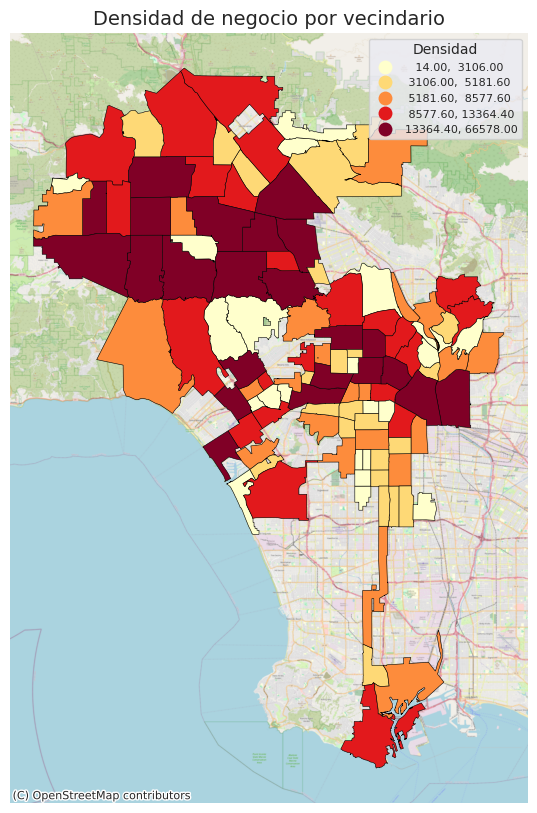

In [68]:
zones_3857 = zones.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
zones_3857.plot(
    column='BUSINESS NAME',
    scheme='quantiles',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    ax=ax,
    legend_kwds={
        'fontsize': 8,
        #'fmt': '%.0f',           # quita los decimales
        'title': 'Densidad',     # título de la leyenda (opcional)
        'frameon': True         # sin recuadro
    }
)

cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    zoom=13
)

plt.title("Densidad de negocio por vecindario", fontsize=14)
ax.set_axis_off()
plt.show()


## Tipo de negocios por vecindario

In [69]:
len(gdf_business['NAICS'].unique())

783

In [ ]:
omega = len(gdf_business['NAICS'])

prob = {code : len(gdf_business[gdf_business['NAICS'] == code])/omega for code in gdf_business['NAICS'].unique()}

In [72]:
gdf_business.head(2)

,LOCATION ACCOUNT #,BUSINESS NAME,STREET ADDRESS,CITY,ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,neighborhoods,Year star,Year end,Month star,Month end
0,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,531100.0,Lessors of real estate (including mini warehou...,8,2020-09-03,NaT,"(33.9597, -118.3028)",33.9597,-118.3028,POINT (-118.3028 33.9597),35.0,Gramercy Park,2020.0,NaN,9.0,NaN
1,0003249387-0001-0,"CHOE SHOW, LLC",711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,531100.0,Lessors of real estate (including mini warehou...,5,2021-03-15,NaT,"(34.0594, -118.3135)",34.0594,-118.3135,POINT (-118.3135 34.0594),52.0,Koreatown,2021.0,NaN,3.0,NaN


In [74]:
counts = (
    gdf_business
    .groupby(['neighborhoods','NAICS'])
    .size()
    .rename('n_i')
    .reset_index()
)

counts

,neighborhoods,NAICS,n_i
0,Adams-Normandie,233210.0,48
1,Adams-Normandie,233220.0,8
2,Adams-Normandie,233310.0,2
3,Adams-Normandie,233320.0,2
4,Adams-Normandie,235110.0,16
...,...,...,...
26716,Woodland Hills,813000.0,14
26717,Woodland Hills,813920.0,4
26718,Woodland Hills,814110.0,4
26719,Woodland Hills,888888.0,46


In [ ]:
counts['N'] = counts.groupby('neighborhoods')['n_i'].transform('sum')

counts

,neighborhoods,NAICS,n_i,N
0,Adams-Normandie,233210.0,48,2852
1,Adams-Normandie,233220.0,8,2852
2,Adams-Normandie,233310.0,2,2852
3,Adams-Normandie,233320.0,2,2852
4,Adams-Normandie,235110.0,16,2852
...,...,...,...,...
26716,Woodland Hills,813000.0,14,26914
26717,Woodland Hills,813920.0,4,26914
26718,Woodland Hills,814110.0,4,26914
26719,Woodland Hills,888888.0,46,26914


In [79]:
# 1) Pivot de conteos
pt = counts.pivot(index='neighborhoods', columns='NAICS', values='n_i').fillna(0)

# 2) Proporciones n_i/N
props = pt.div(pt.sum(axis=1), axis=0)

# 3) Serie de probabilidades P_i
P = pd.Series(prob)

# 4) Cálculo de V
V2 = (props.mul(P, axis=1)).sum(axis=1)
print(V2)

neighborhoods
Adams-Normandie           0.053584
Arleta                    0.026923
Arlington Heights         0.050815
Atwater Village           0.036916
Baldwin Hills/Crenshaw    0.047664
                            ...   
Westwood                  0.044182
Wilmington                0.045684
Windsor Square            0.031569
Winnetka                  0.029351
Woodland Hills            0.029628
Length: 114, dtype: float64


<Axes: xlabel='Year end'>

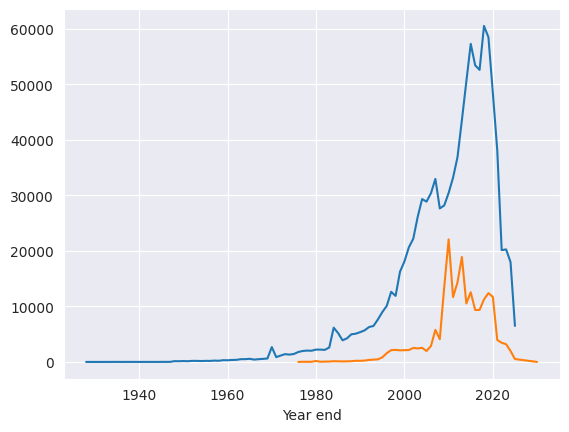

In [ ]:
gdf_business.groupby('Year star')['BUSINESS NAME'].count().plot()
gdf_business.groupby('Year end')['BUSINESS NAME'].count().plot()

np.float64(0.8765688660413989)

In [ ]:
gdf_missing["LOCATION START DATE"].isnull().sum()/len(gdf_missing)

np.float64(0.0004443411446227885)

In [ ]:
#Obteniendo el dia actual
hoy = pd.Timestamp.now()

#Calculando la edad en días de los diferentes negocios. Aquellos que poseen la fecha LOCATION END DATE como null se asigna la fecha de hoy
result = (gdf_missing["LOCATION END DATE"].fillna(hoy) - gdf_missing["LOCATION START DATE"]).dt.days

#Obteniendo la medida de la edad en años
result = round(result/365,0)

# Asigncon la edad de la sociedad
gdf_missing["AGE"] = result

#Resultados
gdf_missing["AGE"].describe()

count   146,219.00
mean         10.31
std          10.30
min         -38.00
25%           3.00
50%           7.00
75%          14.00
max         104.00
Name: AGE, dtype: float64

Parece que tememos un problema con el calculo de AGE pues tenemos resultados negativos, por lo que realizaremos una inspección más a fondo de su naturaleza.

In [ ]:
business_df.describe()

,NAICS,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,AGE
count,"628,889.00","1,607,924.00",1606366,1010608,"1,606,366.00"
mean,"546,537.56",5.89,2006-11-18 23:22:51.861206784,2010-03-01 16:43:33.466745088,8.91
min,"111,110.00",0.00,1920-01-01 00:00:00,1943-02-01 00:00:00,-40.00
25%,"451,110.00",0.00,2000-04-20 00:00:00,2004-08-28 00:00:00,2.00
50%,"541,100.00",5.00,2007-09-30 00:00:00,2010-01-25 00:00:00,6.00
75%,"624,410.00",11.00,2015-10-01 00:00:00,2016-01-01 00:00:00,12.00
max,"999,999.00",15.00,2025-12-31 00:00:00,2030-07-02 00:00:00,104.00
std,"166,037.71",5.13,NaN,NaN,9.70


Existe 1558 registros que cuentan con un valor nulo de la edad.

In [ ]:
mask = business_df["AGE"].isnull()

business_df.loc[mask, :]

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE
523,0000014535-0001-9,BENENSON DANSON,NaN,6922 HOLLYWOOD BLVD #402,LOS ANGELES,90028-6117,6922 HOLLYWOOD 90028-6117,NaN,NaN,NaN,NaN,NaN,13,NaT,2014-08-15,NaN,NaN
864,0000027257-0001-9,PAMELA RAE TRIPP,NaN,10727 WHITE OAK AVENUE #100,GRANADA HILLS,91344-4636,10727 WHITE OAK 91344-4636,NaN,NaN,NaN,NaN,NaN,12,NaT,2004-09-09,NaN,NaN
2376,0000125786-0001-7,JERID R MAY BAUM,NaN,523 W 6TH STREET #1228,LOS ANGELES,90014-1218,523 6TH 90014-1218,NaN,NaN,NaN,NaN,NaN,9,NaT,2009-11-19,NaN,NaN
2837,0000204234-0001-4,LEO BURNETT,NaN,2417 MCKINLEY AVENUE,VENICE,90291-4625,2417 MCKINLEY 90291,NaN,NaN,NaN,NaN,NaN,11,NaT,2004-08-30,NaN,NaN
3038,0000245130-0001-1,JOE/MARY LOU TELLEZ,NaN,10555 SAN FERNANDO ROAD #36 38,PACOIMA,91331-2624,10555 SAN FERNANDO 91331-2624,NaN,NaN,NaN,NaN,NaN,7,NaT,2015-12-31,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571442,0000011648-0001-2,S/S BURBANK PLAZA LLC,NaN,12410 BURBANK BLVD,N HOLLYWOOD,91607-1692,12410 BURBANK 91607-1692,NaN,NaN,NaN,NaN,NaN,2,NaT,2024-12-31,NaN,NaN
1584380,0000014476-0001-0,CINDY LEVIN,NaN,2029 CENTURY PARKS E #6FL,LOS ANGELES,90067-2901,2029 CENTURY 90067-2901,NaN,NaN,NaN,NaN,NaN,5,NaT,2000-06-26,NaN,NaN
1587308,0000624491-0001-3,HARVER DEUTSCH MD,NaN,2070 CENTURY PARKS E,LOS ANGELES,90067-1907,2070 CENTURY 90067-1907,NaN,NaN,NaN,NaN,NaN,5,NaT,1997-10-21,NaN,NaN
1588714,0000995993-0001-1,BARRY VOUGHAN,NaN,2029 CENTURY PARKS E,LOS ANGELES,90067-2901,2029 CENTURY 90067-2901,NaN,NaN,NaN,NaN,NaN,5,NaT,2000-06-01,NaN,NaN


Identificando los registros con datos nulos

Acotando los registros del df a solo la ciudad de los angeles

In [ ]:
business_df.loc[:, "CITY"].value_counts()/len(business_df)

CITY
LOS ANGELES                  0.49
VAN NUYS                     0.04
SHERMAN OAKS                 0.02
NORTH HOLLYWOOD              0.02
WOODLAND HILLS               0.02
                             ... 
KITCHENER, ONTARIO N2G 4X8   0.00
LOS ANELES                   0.00
RANCHITA                     0.00
EDINBURGH EH1 3AN            0.00
YOKNEAU ISRAEL               0.00
Name: count, Length: 6418, dtype: float64

In [ ]:
mask = business_df.loc[:, "CITY"] == "LOS ANGELES"

angeles_bussines_df = business_df.loc[mask, :]

angeles_bussines_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 785808 entries, 0 to 1607923
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   LOCATION ACCOUNT #         785808 non-null  object        
 1   BUSINESS NAME              785808 non-null  object        
 2   DBA NAME                   116121 non-null  object        
 3   STREET ADDRESS             785729 non-null  object        
 4   CITY                       785808 non-null  object        
 5   ZIP CODE                   785808 non-null  object        
 6   LOCATION DESCRIPTION       785707 non-null  object        
 7   MAILING ADDRESS            181549 non-null  object        
 8   MAILING CITY               181558 non-null  object        
 9   MAILING ZIP CODE           181510 non-null  object        
 10  NAICS                      305484 non-null  float64       
 11  PRIMARY NAICS DESCRIPTION  305484 non-null  object      

In [ ]:
angeles_bussines_df.isnull().sum()/len(angeles_bussines_df)

LOCATION ACCOUNT #          0.00
BUSINESS NAME               0.00
DBA NAME                    0.85
STREET ADDRESS              0.00
CITY                        0.00
ZIP CODE                    0.00
LOCATION DESCRIPTION        0.00
MAILING ADDRESS             0.77
MAILING CITY                0.77
MAILING ZIP CODE            0.77
NAICS                       0.61
PRIMARY NAICS DESCRIPTION   0.61
COUNCIL DISTRICT            0.00
LOCATION START DATE         0.00
LOCATION END DATE           0.36
LOCATION                    0.58
AGE                         0.00
YEAR START                  0.00
YEAR END                    0.36
MONTH END                   0.36
MONTH START                 0.00
dtype: float64

In [ ]:
angeles_bussines_df["AGE"].sort_values(ascending=True).head(10)

80040    -40.00
721437   -36.00
764148   -31.00
137507   -28.00
705254   -27.00
750013   -25.00
511963   -25.00
776403   -22.00
961278   -20.00
470859   -19.00
Name: AGE, dtype: float64

In [ ]:
len(angeles_bussines_df.loc[:, "ZIP CODE"].unique())

131561

In [ ]:
len(angeles_bussines_df.loc[:, "NAICS"].unique())

751

In [ ]:
angeles_bussines_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE,YEAR START,YEAR END,MONTH END,MONTH START
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,...,Hardware stores,0,2020-10-01,NaT,"(33.9581, -118.2926)",5.00,"2,020.00",NaN,NaN,10.00
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,...,NaN,8,2020-09-03,NaT,"(33.9597, -118.3028)",5.00,"2,020.00",NaN,NaN,9.00
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,...,NaN,5,2021-03-15,NaT,"(34.0594, -118.3135)",4.00,"2,021.00",NaN,NaN,3.00
5,0003206130-0001-6,FRESH AIR HVAC,NaN,7270 FRANKLIN AVENUE APT #105,LOS ANGELES,90046-3057,7270 Franklin 90046-3057,NaN,NaN,NaN,...,"Plumbing, Heating, and Air-Conditioning Contra...",4,2020-08-05,NaT,"(34.1031, -118.3485)",5.00,"2,020.00",NaN,NaN,8.00
6,0003227519-0001-2,H2ORGANICS PRODUCTS INC,NaN,1205 W 90TH STREET,LOS ANGELES,90044-2029,1205 90TH,NaN,NaN,NaN,...,Wholesale trade agents & brokers,0,2021-01-02,NaT,"(33.9562, -118.2963)",4.00,"2,021.00",NaN,NaN,1.00


In [ ]:
group_by_year_start = angeles_bussines_df.groupby("YEAR START").agg({"YEAR START": "count", "NAICS": "count"})
group_by_year_start.reset_index(inplace=True, names="YEAR")

group_by_year_start

,YEAR,YEAR START,NAICS
0,"1,920.00",1,0
1,"1,926.00",1,0
2,"1,929.00",2,1
3,"1,930.00",1,1
4,"1,934.00",4,3
...,...,...,...
90,"2,021.00",18387,12981
91,"2,022.00",15729,12647
92,"2,023.00",14438,12080
93,"2,024.00",12958,11924


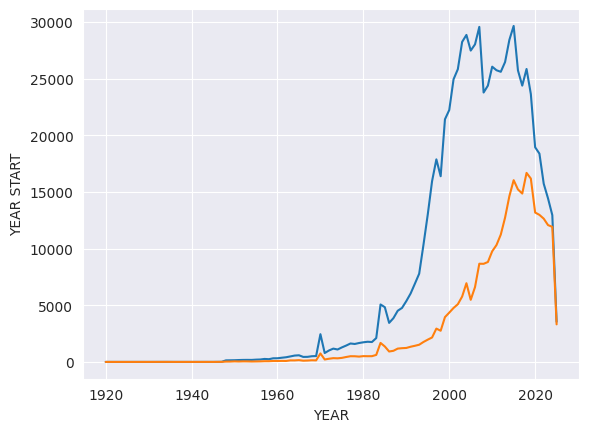

In [ ]:
sns.lineplot(group_by_year_start, x="YEAR", y="YEAR START")
sns.lineplot(group_by_year_start, x="YEAR", y="NAICS")

plt.show()

In [ ]:
mask = angeles_bussines_df.loc[:, "NAICS"].value_counts()/len(angeles_bussines_df)>.001

## Limpieza y tratamiento de datos

Para este primer proceso de limpieza y preprocesamiento de datos, se ajustaran algunos campos los cuales cuentan con caracteristicas o valores que no tiene sentido logico alguno en la base de datos.

In [ ]:
mask = angeles_bussines_df["LOCATION END DATE"] < angeles_bussines_df["LOCATION START DATE"]

angeles_bussines_df.loc[mask, ["AGE", "LOCATION START DATE", "LOCATION END DATE", "YEAR START", "YEAR END", "MONTH END", "MONTH START"]]


,AGE,LOCATION START DATE,LOCATION END DATE,YEAR START,YEAR END,MONTH END,MONTH START
4129,-0.00,2004-02-01,2004-01-07,"2,004.00","2,004.00",1.00,2.00
6833,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
6840,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
6846,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
7063,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
...,...,...,...,...,...,...,...
1580766,-12.00,2002-01-01,1990-06-07,"2,002.00","1,990.00",6.00,1.00
1596227,-6.00,2007-01-01,2001-01-01,"2,007.00","2,001.00",1.00,1.00
1601063,-1.00,2015-10-01,2015-01-01,"2,015.00","2,015.00",1.00,10.00
1605021,-1.00,2007-01-01,2006-03-09,"2,007.00","2,006.00",3.00,1.00


In [ ]:
angeles_error_fecha = angeles_bussines_df.loc[mask, list(angeles_bussines_df.columns)]

In [ ]:
angeles_error_fecha.groupby("YEAR START").agg({"AGE": "count", "LOCATION START DATE": "count", "LOCATION END DATE": "count", "YEAR END": "count", "MONTH END": "count", "MONTH START": "count"}).reset_index(names="YEAR")

,YEAR,AGE,LOCATION START DATE,LOCATION END DATE,YEAR END,MONTH END,MONTH START
0,"1,984.00",1,1,1,1,1,1
1,"1,994.00",1,1,1,1,1,1
2,"1,997.00",1,1,1,1,1,1
3,"1,999.00",2,2,2,2,2,2
4,"2,000.00",1,1,1,1,1,1
5,"2,001.00",4,4,4,4,4,4
6,"2,002.00",3,3,3,3,3,3
7,"2,003.00",15,15,15,15,15,15
8,"2,004.00",15,15,15,15,15,15
9,"2,005.00",11,11,11,11,11,11


In [ ]:
angeles_error_fecha.describe()

,NAICS,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,AGE,YEAR START,YEAR END,MONTH END,MONTH START
count,7.00,378.00,378,378,378.00,378.00,378.00,378.00,378.00
mean,"465,111.43",7.46,2007-04-24 09:27:37.142857216,2003-07-21 10:36:11.428571392,-3.76,"2,007.23","2,003.28",4.07,1.88
min,"238,990.00",0.00,1984-02-09 00:00:00,1970-09-15 00:00:00,-40.00,"1,984.00","1,970.00",1.00,1.00
25%,"453,990.00",4.00,2007-01-01 00:00:00,2002-01-01 00:00:00,-5.00,"2,007.00","2,002.00",1.00,1.00
50%,"522,100.00",9.00,2007-01-01 00:00:00,2004-01-01 00:00:00,-3.00,"2,007.00","2,004.00",1.00,1.00
75%,"527,210.00",11.00,2007-01-01 00:00:00,2006-01-01 00:00:00,-1.00,"2,007.00","2,006.00",7.00,1.00
max,"532,290.00",15.00,2023-03-30 00:00:00,2018-11-05 00:00:00,-0.00,"2,023.00","2,018.00",12.00,12.00
std,"105,581.73",4.48,NaN,NaN,5.05,3.35,5.92,3.93,2.33


In [ ]:
mask = angeles_error_fecha["YEAR START"] == 2007

angeles_error_fecha.loc[mask, :]

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE,YEAR START,YEAR END,MONTH END,MONTH START
6833,0002237554-0001-6,JOSEPH TAKI EDEN,NaN,NaN,LOS ANGELES,-,NaN,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
6840,0002238391-0001-8,KEVIN MAX HAUB,NaN,NaN,LOS ANGELES,-,NaN,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
6846,0002239287-0001-1,MICHAEL ANTHONY MARTINEZ,NaN,902 15TH PLACE,LOS ANGELES,-,902 15TH,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
7063,0002281309-0001-2,DEPORTES GUADALAJARA,NaN,1316 E FLORENCE AVENUE,LOS ANGELES,90001-1935,1316 FLORENCE 90001-1935,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
7521,0002375517-0001-1,ROBERT RICHTER MD,NaN,6360 WILSHIRE BLVD SUITE #203,LOS ANGELES,90048-5606,6360 WILSHIRE 90048-5606,NaN,NaN,NaN,...,NaN,5,2007-01-01,2005-01-01,NaN,-2.00,"2,007.00","2,005.00",1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318142,0002397502-0001-2,TIERRA LOAN CENTER INC,NaN,6345 BALBOA BLVD UNIT #231,LOS ANGELES,-,6345 BALBOA,NaN,NaN,NaN,...,NaN,0,2007-01-01,2006-06-26,NaN,-1.00,"2,007.00","2,006.00",6.00,1.00
1357343,0002089482-0001-5,MAM FINANCIAL,NaN,1801 CENTURY PARKS E #2400,LOS ANGELES,90067-2326,1801 CENTURY 90067-2326,NaN,NaN,NaN,...,NaN,5,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
1382261,0002164709-0001-9,RENESANS DEVELOPMENT CORP,NaN,1855 INDUSTRIAL STREET UNIT #312,LOS ANGELES,90021-1256,1855 INDUSTRIAL 90021-1256,NaN,NaN,NaN,...,NaN,14,2007-01-01,2005-01-10,NaN,-2.00,"2,007.00","2,005.00",1.00,1.00
1596227,0002470968-0001-6,ALDRICH LAW GROUP LLC,NaN,1800 CENTURY PARKS E #600,LOS ANGELES,90067-1508,1800 CENTURY 90067-1508,NaN,NaN,NaN,...,NaN,5,2007-01-01,2001-01-01,NaN,-6.00,"2,007.00","2,001.00",1.00,1.00


In [ ]:
angeles_error_fecha.loc[mask, :]